In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [17]:
course_reviews_data = pd.read_csv("2024_02_21_all_reviews", index_col=0)
df = pd.DataFrame(course_reviews_data)

In [18]:
df.head()

,course_code,status_code,star_count,prof_name,prof_slug,grade,reviewer_name,date,review_text,review_id
0,NFSC112,200,4,Abani Pradhan,/professor/pradhan,Expecting an A,Anonymous,12/23/2023,"Didn't learn anything, but didn't need to. Eas...",review-31256
1,NFSC112,200,5,Qin Wang,/professor/wang_qin,Expecting an A,Anonymous,12/18/2023,Easy class. The lectures are asynchronous but ...,review-30485
2,NFSC112,200,5,Xiaoxue Jia,/professor/jia_xiaoxue,Expecting an A,Anonymous,12/13/2023,She is amazing with ADS and helpful with answe...,review-29852
3,NFSC112,200,2,Abani Pradhan,/professor/pradhan,Expecting a B-,Anonymous,12/06/2023,Easy class as long as you actually watch the l...,review-28855
4,NFSC112,200,5,Qin Wang,/professor/wang_qin,Expecting an A,Anonymous,11/26/2023,"she is a good lecturer, nfsc 112, is ""chill,"" ...",review-28192


In [19]:
# extract dept and course_num using a regular expression
df[['dept', 'course_num']] = df['course_code'].str.extract('([A-Z]{4})([0-9]+[A-Z]*)', expand=True)

# rename grade => expected_grade
df = df.rename(columns={"grade": "expected_grade"})

# convert date => datetime
df['date'] = pd.to_datetime(df['date'])

# drop status_code, prof_slug, review_id, and course_code
df = df.loc[:, ~df.columns.isin(['status_code', 'prof_slug','review_id'])]

df['star_count'] = pd.to_numeric(df['star_count'])

df.head(5)

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num
0,NFSC112,4,Abani Pradhan,Expecting an A,Anonymous,2023-12-23,"Didn't learn anything, but didn't need to. Eas...",NFSC,112
1,NFSC112,5,Qin Wang,Expecting an A,Anonymous,2023-12-18,Easy class. The lectures are asynchronous but ...,NFSC,112
2,NFSC112,5,Xiaoxue Jia,Expecting an A,Anonymous,2023-12-13,She is amazing with ADS and helpful with answe...,NFSC,112
3,NFSC112,2,Abani Pradhan,Expecting a B-,Anonymous,2023-12-06,Easy class as long as you actually watch the l...,NFSC,112
4,NFSC112,5,Qin Wang,Expecting an A,Anonymous,2023-11-26,"she is a good lecturer, nfsc 112, is ""chill,"" ...",NFSC,112


In [20]:
# clean up expected grades
df.expected_grade.value_counts()

Expecting an A     9181
Expecting an A+    4014
Expecting an A-    2612
Expecting a B      2408
Expecting a B+     1566
Expecting a B-      645
Expecting a C       631
Expecting a C+      290
Expecting a C-      215
Expecting a W       113
Expecting a D        80
Expecting a P        80
Expecting an F       70
Expecting a D+       44
Expecting a D-       10
Expecting a a         8
Expecting a ?         8
Expecting a b         7
Expecting an XF       6
Expecting a c         5
Expecting a B?        5
Expecting a BC        3
Expecting a b+        3
Expecting a d         2
Expecting a c-        2
Expecting a ??        2
Expecting a a-        1
Expecting a 95        1
Expecting a 85        1
Expecting a CB        1
Expecting a F+        1
Expecting a CD        1
Expecting a 74        1
Expecting a -         1
Expecting a 65        1
Expecting a I         1
Expecting a C?        1
Expecting a b-        1
Expecting a s         1
Expecting a -A        1
Expecting a AA        1
Expecting a A?  

In [21]:
df['expected_grade'] = df['expected_grade'].str.extract('(Expecting a[n]? )([A-z0-9\-?+]{1,2})', expand=True)[1]
df.expected_grade = df.expected_grade.str.upper()
df.expected_grade.value_counts()

A     9189
A+    4014
A-    2613
B     2415
B+    1569
B-     646
C      636
C+     290
C-     217
W      113
D       82
P       80
F       70
D+      44
D-      10
?        8
XF       6
B?       5
BC       3
??       2
C?       2
65       1
95       1
85       1
CB       1
F+       1
CD       1
-        1
74       1
I        1
S        1
-A       1
AA       1
A?       1
AU       1
Name: expected_grade, dtype: int64

In [22]:
# map letter grades to numeric
grade_mapper = {
    "A+":4.0,
    "A":4.0,
    "AA":4.0,
    "A?":4.0,
    "A-":3.7,
    "-A":3.7,
    "B+":3.3,
    "B":3.0,
    "B?":3.0,
    "B-":2.7,
    "BC":2.5,
    "CB":2.5,
    "C+":2.3,
    "C":2.0,
    "C?":2.0,
    "C-":1.7,
    "CD":1.5,
    "D+":1.3,
    "D":1.0,
    "D-":0.7,
    "F":0,
    "F+":0,
    "XF":0,
    "P":None,
    "S":None,
    "I":None,
    "-":None,
    "AU":None,
    "??":None,
    "?":None,
    "W":None
}

def map_grades_to_gpa(letter_grade):
    if pd.isna(letter_grade) or letter_grade == np.nan :
        return None
    else:
        if letter_grade.isnumeric():
            return None
        elif ( letter_grade in grade_mapper.keys()):
            return grade_mapper[letter_grade]
        else:
            print("Not in mapper: " +letter_grade)
            return None

df['gpa_grade'] = df['expected_grade'].apply(map_grades_to_gpa)


In [23]:
term_mapper = {
    2: "Spring",
    3: "Spring",
    4: "Spring",
    6: "Summer",
    7: "Summer",
    9: "Fall",
    10: "Fall",
    11: "Fall",
}

def date_to_term_finder(date):
    month = date.month
    day = date.day
    if (month == 5 and day <= 20) or (month == 1 and day > 20):
        term = "Spring"
    elif (month == 5 and day > 20) or (month == 8 and day <= 20):
        term = "Summer"
    elif (month == 8 and day > 20) or (month == 12 and day <= 20):
        term = "Fall"
    elif month == 12 and day > 20 or (month == 1 and day <= 20):
        term = "Winter"
    else:
        term = term_mapper.get(month, "Unknown")
    return term

def date_to_year_finder(date):
  return date.year

new_terms_df = df['date'].apply(date_to_term_finder)
new_year_df = df['date'].apply(date_to_year_finder)


df['term'] = new_terms_df
df['year'] = new_year_df

df.head(10)

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,gpa_grade,term,year
0,NFSC112,4,Abani Pradhan,A,Anonymous,2023-12-23,"Didn't learn anything, but didn't need to. Eas...",NFSC,112,4.0,Winter,2023
1,NFSC112,5,Qin Wang,A,Anonymous,2023-12-18,Easy class. The lectures are asynchronous but ...,NFSC,112,4.0,Fall,2023
2,NFSC112,5,Xiaoxue Jia,A,Anonymous,2023-12-13,She is amazing with ADS and helpful with answe...,NFSC,112,4.0,Fall,2023
3,NFSC112,2,Abani Pradhan,B-,Anonymous,2023-12-06,Easy class as long as you actually watch the l...,NFSC,112,2.7,Fall,2023
4,NFSC112,5,Qin Wang,A,Anonymous,2023-11-26,"she is a good lecturer, nfsc 112, is ""chill,"" ...",NFSC,112,4.0,Fall,2023
5,NFSC112,5,Qin Wang,A+,Anonymous,2022-12-28,super chill and easy class... lectures are onl...,NFSC,112,4.0,Winter,2022
6,NFSC112,4,Qin Wang,A,Anonymous,2022-12-12,"Very chill class, meets once a week for ""discu...",NFSC,112,4.0,Fall,2022
7,NFSC112,3,Qin Wang,B+,Anonymous,2022-12-11,She's alright. Kinda boring since all she does...,NFSC,112,3.3,Fall,2022
8,NFSC112,5,Qin Wang,A+,Anonymous,2021-12-31,"Super chill class, do the study guide slides a...",NFSC,112,4.0,Winter,2021
9,NFSC112,5,Shraddha Karanth,A-,Anonymous,2020-12-04,She's always really prepared for class and not...,NFSC,112,3.7,Fall,2020


In [24]:
df['gpa_grade'].value_counts()

4.0    13205
3.7     2614
3.0     2420
3.3     1569
2.7      646
2.0      638
2.3      290
1.7      217
1.0       82
0.0       77
1.3       44
0.7       10
2.5        4
1.5        1
Name: gpa_grade, dtype: int64

In [25]:
term_counts = df['term'].value_counts()
term_counts

Fall      10541
Spring     8100
Winter     4354
Summer     3168
Name: term, dtype: int64

In [26]:
df_cmsc = df[df['dept'] == 'CMSC']
df_cmsc

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,gpa_grade,term,year
540,CMSC436,3,Adam Porter,A,Anonymous,2023-12-28,This class is mid. Android programming as a fi...,CMSC,436,4.0,Winter,2023
541,CMSC436,3,Herve Franceschi,A+,Anonymous,2023-12-23,Very average CS professor. Doesn't teach that ...,CMSC,436,4.0,Winter,2023
542,CMSC436,4,Adam Porter,A-,Anonymous,2023-12-13,Overall the class was fairly easy and the TAs ...,CMSC,436,3.7,Fall,2023
543,CMSC436,5,Michael Marsh,A-,Anonymous,2023-05-23,Marsh is a very good professor. You can tell h...,CMSC,436,3.7,Summer,2023
544,CMSC436,5,Michael Marsh,A+,Anonymous,2023-05-22,absolute goat. marsh made the class self paced...,CMSC,436,4.0,Summer,2023
...,...,...,...,...,...,...,...,...,...,...,...,...
25693,CMSC395,5,Elias Gonzalez,A+,Anonymous,2022-12-10,The class is just very chill in general when i...,CMSC,395,4.0,Fall,2022
25694,CMSC488B,5,Leonidas Lampropoulos,A,fiftyseven,2022-05-16,Genuinely amazing professor. Taught the concep...,CMSC,488B,4.0,Spring,2022
25695,CMSC488B,4,Leonidas Lampropoulos,B+,Anonymous,2022-04-19,"I didn't take away much from this class, but t...",CMSC,488B,3.3,Spring,2022
25837,CMSC398D,5,Wiseley Wong,A,Anonymous,2023-05-25,This class wasn't taught by Wong but it was an...,CMSC,398D,4.0,Summer,2023


In [27]:
# assigning levels to each course for the purpose of analysis
def course_level_finder(course_code):
    course_level_pattern = r'([0-9]{3})[A-Z]?'
    course_regex = re.compile(course_level_pattern)
    course_level_match = course_regex.search(course_code)
    if course_level_match:
        course_level = int(course_level_match.group(1))
        if course_level >= 100 and course_level < 200:
            return 100
        elif course_level >= 200 and course_level < 300:
            return 200
        elif course_level >= 300 and course_level < 400:
            return 300
        elif course_level >= 400 and course_level < 500:
            return 400
        elif course_level >= 500 and course_level < 600:
            return 500
        elif course_level >= 600 and course_level < 700:
            return 600
        elif course_level >= 700 and course_level < 800:
            return 700
        else:
            return 800
df_cmsc_copy = df_cmsc.copy()
df_cmsc_copy.loc[:, 'level'] = df_cmsc['course_num'].apply(course_level_finder)
df_cmsc_copy


,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,gpa_grade,term,year,level
540,CMSC436,3,Adam Porter,A,Anonymous,2023-12-28,This class is mid. Android programming as a fi...,CMSC,436,4.0,Winter,2023,400
541,CMSC436,3,Herve Franceschi,A+,Anonymous,2023-12-23,Very average CS professor. Doesn't teach that ...,CMSC,436,4.0,Winter,2023,400
542,CMSC436,4,Adam Porter,A-,Anonymous,2023-12-13,Overall the class was fairly easy and the TAs ...,CMSC,436,3.7,Fall,2023,400
543,CMSC436,5,Michael Marsh,A-,Anonymous,2023-05-23,Marsh is a very good professor. You can tell h...,CMSC,436,3.7,Summer,2023,400
544,CMSC436,5,Michael Marsh,A+,Anonymous,2023-05-22,absolute goat. marsh made the class self paced...,CMSC,436,4.0,Summer,2023,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25693,CMSC395,5,Elias Gonzalez,A+,Anonymous,2022-12-10,The class is just very chill in general when i...,CMSC,395,4.0,Fall,2022,300
25694,CMSC488B,5,Leonidas Lampropoulos,A,fiftyseven,2022-05-16,Genuinely amazing professor. Taught the concep...,CMSC,488B,4.0,Spring,2022,400
25695,CMSC488B,4,Leonidas Lampropoulos,B+,Anonymous,2022-04-19,"I didn't take away much from this class, but t...",CMSC,488B,3.3,Spring,2022,400
25837,CMSC398D,5,Wiseley Wong,A,Anonymous,2023-05-25,This class wasn't taught by Wong but it was an...,CMSC,398D,4.0,Summer,2023,300


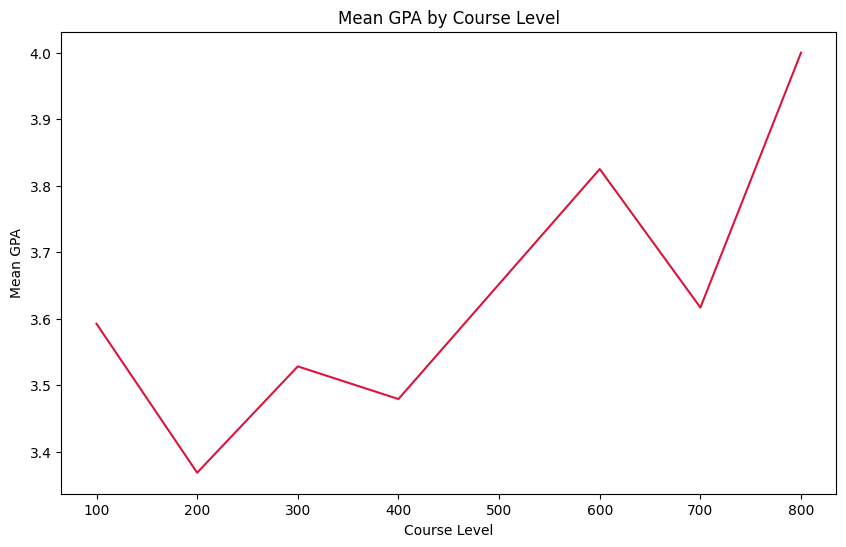

In [28]:
# Grouping by 'level' and calculating mean GPA for each level
mean_gpa_by_level = df_cmsc_copy.groupby('level')['gpa_grade'].mean()

# Plotting the column chart
plt.figure(figsize=(10, 6))
mean_gpa_by_level.plot(kind='line', color='crimson')
plt.title('Mean GPA by Course Level')
plt.xlabel('Course Level')
plt.ylabel('Mean GPA')
plt.xticks(rotation=0)
plt.show()


In [29]:
'''
It is interesting to note how there is not a consistent decline in terms of the GPA as the course levels rise. Courses starting level 600 are courses
taken by graduate students and so they may not be the best representation of what a typical graduate level course average may be like.
'''

'\nIt is interesting to note how there is not a consistent decline in terms of the GPA as the course levels rise. Courses starting level 600 are courses \ntaken by graduate students and so they may not be the best representation of what a typical graduate level course average may be like.\n'

In [30]:
#Finding the number of data points available for each level
data_points_per_level = df_cmsc_copy['level'].value_counts().sort_index(level='level')
data_points_per_level

100    680
200    642
300    569
400    786
600      4
700     14
800      5
Name: level, dtype: int64

In [31]:
'''
The results above confirm the observation made previously in regards to the plot being inaccurate for graduate level courses.
'''

'\nThe results above confirm the observation made previously in regards to the plot being inaccurate for graduate level courses.\n'

In [32]:
# It would be interesting to see determine how the mean gpa of students taking the course changed as the years have passed by.
'''
We can perform a hypothesis test for this. Based on the technological advancements that have taken place in the past several years I am going to
choose the following as my null hypothesis and the alternate hypothesis:

Null Hypothesis: There is no significant difference in mean GPA across different levels of CS courses and different years.
Alternative Hypothesis: There is a significant difference in mean GPA across different levels of CS courses and different years.

For the analysis we will be assuming that the significance level is 0.05
'''

'\nWe can perform a hypothesis test for this. Based on the technological advancements that have taken place in the past several years I am going to \nchoose the following as my null hypothesis and the alternate hypothesis:\n\nNull Hypothesis: There is no significant difference in mean GPA across different levels of CS courses and different years.\nAlternative Hypothesis: There is a significant difference in mean GPA across different levels of CS courses and different years.\n\nFor the analysis we will be assuming that the significance level is 0.05\n'

In [33]:
df_cmsc_copy.isnull().sum()

course_code         0
star_count          0
prof_name           0
expected_grade    482
reviewer_name       0
date                0
review_text         1
dept                0
course_num          0
gpa_grade         521
term                0
year                0
level               0
dtype: int64

In [34]:
'''
Since we do have null values for the gpa grade as depicted above we will be getting rid of all of these values to avoid any form of hindrance in calculating
the necessary p_value
'''

'\nSince we do have null values for the gpa grade as depicted above we will be getting rid of all of these values to avoid any form of hindrance in calculating\nthe necessary p_value\n'

In [35]:
# updating df_cmsc_copy to get rid of all those fields that don't have a gpa_grade value associated with them.
df_cmsc_copy = df_cmsc_copy.dropna(subset=['gpa_grade'])
df_cmsc_copy

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,gpa_grade,term,year,level
540,CMSC436,3,Adam Porter,A,Anonymous,2023-12-28,This class is mid. Android programming as a fi...,CMSC,436,4.0,Winter,2023,400
541,CMSC436,3,Herve Franceschi,A+,Anonymous,2023-12-23,Very average CS professor. Doesn't teach that ...,CMSC,436,4.0,Winter,2023,400
542,CMSC436,4,Adam Porter,A-,Anonymous,2023-12-13,Overall the class was fairly easy and the TAs ...,CMSC,436,3.7,Fall,2023,400
543,CMSC436,5,Michael Marsh,A-,Anonymous,2023-05-23,Marsh is a very good professor. You can tell h...,CMSC,436,3.7,Summer,2023,400
544,CMSC436,5,Michael Marsh,A+,Anonymous,2023-05-22,absolute goat. marsh made the class self paced...,CMSC,436,4.0,Summer,2023,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25693,CMSC395,5,Elias Gonzalez,A+,Anonymous,2022-12-10,The class is just very chill in general when i...,CMSC,395,4.0,Fall,2022,300
25694,CMSC488B,5,Leonidas Lampropoulos,A,fiftyseven,2022-05-16,Genuinely amazing professor. Taught the concep...,CMSC,488B,4.0,Spring,2022,400
25695,CMSC488B,4,Leonidas Lampropoulos,B+,Anonymous,2022-04-19,"I didn't take away much from this class, but t...",CMSC,488B,3.3,Spring,2022,400
25837,CMSC398D,5,Wiseley Wong,A,Anonymous,2023-05-25,This class wasn't taught by Wong but it was an...,CMSC,398D,4.0,Summer,2023,300


In [36]:
data_points_per_level = df_cmsc_copy['level'].value_counts().sort_index(level='level')
data_points_per_level

100    559
200    527
300    452
400    627
600      4
700      6
800      4
Name: level, dtype: int64

In [37]:
'''
Since the number of fields available for levels 600,700,800 are extremely low we will be not considering them for our analysis to avoid any form of outliers in
the data.
'''

'\nSince the number of fields available for levels 600,700,800 are extremely low we will be not considering them for our analysis to avoid any form of outliers in\nthe data.\n'

In [53]:
#updating df_cmsc_copy to get rid of any record fields that have level 600,700,800 associated with them
df_cmsc_copy = df_cmsc_copy[df_cmsc_copy['level'].isin([100, 200, 300, 400])]
df_cmsc_copy.drop_duplicates(inplace=True)
df_cmsc_copy

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,gpa_grade,term,year,level
540,CMSC436,3,Adam Porter,A,Anonymous,2023-12-28,This class is mid. Android programming as a fi...,CMSC,436,4.0,Winter,2023,400
541,CMSC436,3,Herve Franceschi,A+,Anonymous,2023-12-23,Very average CS professor. Doesn't teach that ...,CMSC,436,4.0,Winter,2023,400
542,CMSC436,4,Adam Porter,A-,Anonymous,2023-12-13,Overall the class was fairly easy and the TAs ...,CMSC,436,3.7,Fall,2023,400
543,CMSC436,5,Michael Marsh,A-,Anonymous,2023-05-23,Marsh is a very good professor. You can tell h...,CMSC,436,3.7,Summer,2023,400
544,CMSC436,5,Michael Marsh,A+,Anonymous,2023-05-22,absolute goat. marsh made the class self paced...,CMSC,436,4.0,Summer,2023,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25693,CMSC395,5,Elias Gonzalez,A+,Anonymous,2022-12-10,The class is just very chill in general when i...,CMSC,395,4.0,Fall,2022,300
25694,CMSC488B,5,Leonidas Lampropoulos,A,fiftyseven,2022-05-16,Genuinely amazing professor. Taught the concep...,CMSC,488B,4.0,Spring,2022,400
25695,CMSC488B,4,Leonidas Lampropoulos,B+,Anonymous,2022-04-19,"I didn't take away much from this class, but t...",CMSC,488B,3.3,Spring,2022,400
25837,CMSC398D,5,Wiseley Wong,A,Anonymous,2023-05-25,This class wasn't taught by Wong but it was an...,CMSC,398D,4.0,Summer,2023,300


In [54]:
#categorizing gpa into different categories for purpose of ANOVA test
def gpa_grade_to_category(gpa_grade):
  gpa = int(gpa_grade)
  if gpa >= 0.0 and gpa <= 2.5:
    return 1
  elif gpa > 2.5 and gpa <= 3.5:
    return 2
  else:
    return 3

updated_df_cmsc = df_cmsc_copy.copy()
updated_df_cmsc.loc[:,'gpa_category'] = df_cmsc_copy['gpa_grade'].apply(gpa_grade_to_category)
updated_df_cmsc

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,gpa_grade,term,year,level,gpa_category
540,CMSC436,3,Adam Porter,A,Anonymous,2023-12-28,This class is mid. Android programming as a fi...,CMSC,436,4.0,Winter,2023,400,3
541,CMSC436,3,Herve Franceschi,A+,Anonymous,2023-12-23,Very average CS professor. Doesn't teach that ...,CMSC,436,4.0,Winter,2023,400,3
542,CMSC436,4,Adam Porter,A-,Anonymous,2023-12-13,Overall the class was fairly easy and the TAs ...,CMSC,436,3.7,Fall,2023,400,2
543,CMSC436,5,Michael Marsh,A-,Anonymous,2023-05-23,Marsh is a very good professor. You can tell h...,CMSC,436,3.7,Summer,2023,400,2
544,CMSC436,5,Michael Marsh,A+,Anonymous,2023-05-22,absolute goat. marsh made the class self paced...,CMSC,436,4.0,Summer,2023,400,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25693,CMSC395,5,Elias Gonzalez,A+,Anonymous,2022-12-10,The class is just very chill in general when i...,CMSC,395,4.0,Fall,2022,300,3
25694,CMSC488B,5,Leonidas Lampropoulos,A,fiftyseven,2022-05-16,Genuinely amazing professor. Taught the concep...,CMSC,488B,4.0,Spring,2022,400,3
25695,CMSC488B,4,Leonidas Lampropoulos,B+,Anonymous,2022-04-19,"I didn't take away much from this class, but t...",CMSC,488B,3.3,Spring,2022,400,2
25837,CMSC398D,5,Wiseley Wong,A,Anonymous,2023-05-25,This class wasn't taught by Wong but it was an...,CMSC,398D,4.0,Summer,2023,300,3


In [57]:
# Performing ANOVA analysis here since we are trying to perform relation between three different categories here: course_level, year, gpa_category
new = ols('gpa_category ~ C(level) * C(year)', data=updated_df_cmsc).fit()
an =  sm.stats.anova_lm(new, typ=2)
an

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 15
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 51, but rank is 49
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(level),62.075616,3.0,42.426553,9.165493e-11
C(year),12.561892,17.0,1.515110,9.130680e-02
C(level):C(year),38.707890,51.0,1.556207,8.461505e-03
Residual,1019.802480,2091.0,NaN,NaN


In [ ]:
'''
Since our p-value is 0.008461505 we reject our null hypothesis and as it stands there is a significant difference in mean GPA across different levels
of CS courses over course of several years.
'''

<Figure size 1200x600 with 0 Axes>

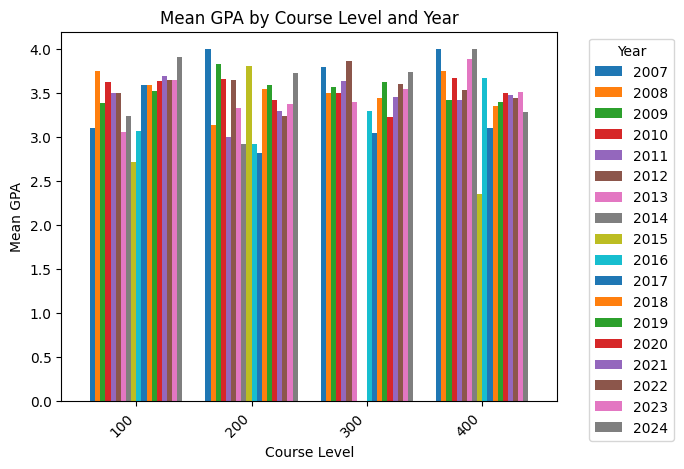

In [58]:
mean_gpa_by_level_year = updated_df_cmsc.groupby(['level', 'year'])['gpa_grade'].mean()
mean_gpa_by_level_year = mean_gpa_by_level_year.unstack()

# Plotting the bar plot
plt.figure(figsize=(12, 6))
mean_gpa_by_level_year.plot(kind='bar', width=0.8)
plt.title('Mean GPA by Course Level and Year')
plt.xlabel('Course Level')
plt.ylabel('Mean GPA')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()


In [42]:
'''
The graph above is also suggestive of the fact that there is a considerable difference in the GPA levels with the passage of time amongst the many courses
that constitute our level categories.
'''